# Tunned_LSTM_fixed
**Organized LSTM pipeline for stock price prediction (cleaned & step-by-step)**

This notebook contains a modular, reproducible LSTM pipeline for stock price forecasting using `yfinance`, `pandas`, `scikit-learn`, and `TensorFlow / Keras`.

**Structure**
1. Setup & installs (if needed)
2. Imports & constants
3. Data loading
4. EDA & summary statistics
5. Preprocessing (skew handling, scaling)
6. Sequence creation for LSTM
7. Model building & training utilities
8. Evaluation & plotting
9. Example pipeline (safe-run guard)

In [1]:
# 1. Imports & constants
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

# Keras/TensorFlow imports (used only when training)
try:
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
except Exception as e:
    # If TensorFlow is not installed, you can still read/run non-training cells.
    print('TensorFlow not available. Training-related cells will require TensorFlow to be installed.')


# Reduce TF verbosity if running training later
os.environ.setdefault('TF_CPP_MIN_LOG_LEVEL', '2')
plt.style.use('default')

##### Fetch Live stock data 

In [2]:
def load_ticker_data(
    ticker_symbol="CESC.NS", period="1mo", interval="5m", use_yfinance=True
):
    """Load OHLCV data for the ticker and return a DataFrame with date-only index.
    Columns returned: ['Open', 'High', 'Low', 'Close', 'Volume']"""
    if use_yfinance:
        try:
            import yfinance as yf
        except Exception:
            print("yfinance not installed. Please install it to load ticker data.")
        ticker = yf.Ticker(ticker_symbol)
        df = ticker.history(period=period, interval=interval)
    else:
        raise ValueError("Only yfinance loader implemented.")

    df = df[["Open", "High", "Low", "Close", "Volume"]].copy()
    # Convert index to datetime.date to remove time component
    df.index = pd.to_datetime(df.index).date
    # Ensure numeric dtypes
    df = df.apply(pd.to_numeric, errors="coerce")
    return df


# Example (do not run unless you want to fetch data now)
# df = load_ticker_data("CESC.NS", period="3y", interval="1d")
# df = df.round(2)  # Round to 2 decimal places
# df = df.dropna()  # Drop any rows with NaN values
# print("Data loaded successfully. Here's a preview:")
# print(df.tail())

## 3. Exploratory Data Analysis (EDA)

Quick EDA: summary statistics, missing values, and distributions. Check for skewness (especially for `Volume`).

In [3]:
def quick_eda(df):
    display(df.describe().T.round(2))
    print('\nSkewness:')
    skewness = df.select_dtypes(include=[np.number]).skew()
    display(skewness.round(2))
    # Histogram of Close price
    plt.figure(figsize=(10,4))
    sb.histplot(df['Close'].dropna(), kde=True)
    plt.title('Close Price Distribution')
    plt.show()

# quick_eda(df.round(2))

## 4. Preprocessing utilities

- Rounds numeric columns
- Handles volume skew (log1p recommended)
- Scales features using `MinMaxScaler` and returns scaler for inverse transform


In [4]:
def round_numeric_columns(df, decimals=2):
    df = df.copy()
    num_cols = df.select_dtypes(include=[np.number]).columns
    df[num_cols] = df[num_cols].round(decimals)
    return df

def handle_volume_skew(df, method='log1p'):
    df = df.copy()
    if 'Volume' not in df.columns:
        return df
    if method == 'log1p':
        df['Volume'] = np.log1p(df['Volume'])
    elif method is None:
        pass
    else:
        raise ValueError('Unsupported method for volume skew handling')
    return df

def scale_features(df, feature_cols=None):
    if feature_cols is None:
        feature_cols = df.columns.tolist()
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df[feature_cols].values)
    return scaled, scaler, feature_cols

# Example usage:
# df2 = round_numeric_columns(df, 2)
# df2 = handle_volume_skew(df2)
# scaled, scaler, feature_cols = scale_features(df2)

## 5. Sequence creation for LSTM

Create sequences shaped `(samples, timesteps, features)` and targets. By default the target is the `Close` column.


In [5]:
"""dataset: numpy array (n_samples, n_features)
target_col_index: column index of 'Close' inside dataset's features
Returns: X (samples, timesteps, features), y (samples,)"""


def create_sequences(dataset, lookback=60, target_col_index=3):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        X.append(dataset[i : i + lookback])
        y.append(dataset[i + lookback, target_col_index])
    X = np.array(X)
    y = np.array(y)
    return X, y

# X, y = create_sequences(scaled, lookback=30, target_col_index=feature_cols.index('Close'))

## 6. Model building & training utilities

Functions to build a simple LSTM and train with callbacks (EarlyStopping, ReduceLROnPlateau).

In [6]:
def build_lstm_model(input_shape, units=100, dropout=0.4, lr=0.001):
    try:
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import LSTM, Dense, Dropout
        from tensorflow.keras.optimizers import Adam
    except Exception as e:
        raise ImportError('TensorFlow/Keras not installed or unavailable. Install tensorflow to build model.')

    model = Sequential()
    model.add(LSTM(units, return_sequences=False, input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')
    return model

def train_model(model, X_train, y_train, X_val=None, y_val=None, epochs=50, batch_size=32, model_path=None):
    callbacks = []
    try:
        from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)
        ]
        if model_path:
            callbacks.append(ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True))
    except Exception:
        pass

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val) if X_val is not None else None,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    return history

## 7. Evaluation & plotting utilities

Utilities to inverse-transform predictions and compute metrics such as RMSE, MAE, R² and MAPE, plus plotting helper.

In [7]:
def inverse_transform_predictions(y_scaled, scaler, feature_count, target_col_index=3):
    arr = np.zeros((len(y_scaled), feature_count))
    arr[:, target_col_index] = y_scaled
    inv = scaler.inverse_transform(arr)[:, target_col_index]
    return inv

def compute_metrics(y_true, y_pred):
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    with np.errstate(divide='ignore', invalid='ignore'):
        mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, np.nan, y_true))) * 100
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}

def plot_actual_vs_pred(dates, actual, predicted, title='Actual vs Predicted'):
    plt.figure(figsize=(12,6))
    plt.plot(dates, actual, label='Actual', linewidth=1.5)
    plt.plot(dates, predicted, label='Predicted', linewidth=1.5)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## 8. Example pipeline (full flow)
The following cell ties everything together. **It will not run by default** — a flag `run_full_pipeline = False` is present.
Set the flag to `True` if you want to run the whole pipeline (including training) **and understand that training may take time**.


,count,mean,std,min,25%,50%,75%,max
Open,1239.0,96.46,45.25,44.39,65.50,72.90,137.20,202.80
High,1239.0,98.06,46.15,45.43,66.17,74.14,139.48,206.28
Low,1239.0,94.85,44.30,43.76,64.70,72.05,134.39,196.70
Close,1239.0,96.32,45.20,44.38,65.42,72.94,137.01,202.32
Volume,1239.0,4909074.48,5932416.14,0.00,1852885.00,3185760.00,5505923.50,70281201.00



Skewness:


Open      0.82
High      0.82
Low       0.83
Close     0.82
Volume    4.70
dtype: float64

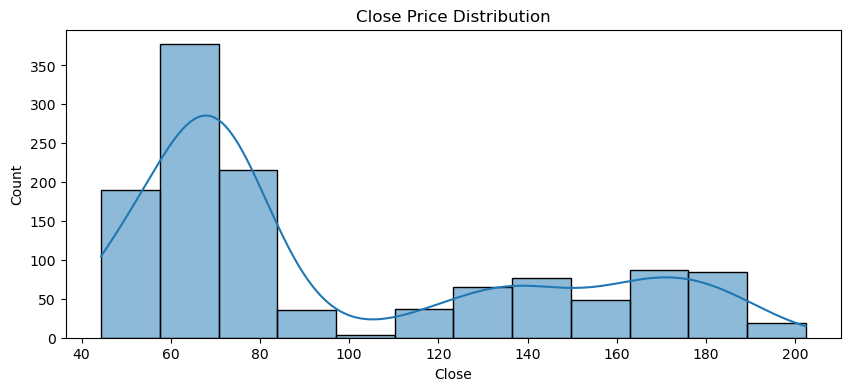

Shapes -> (961, 30, 5) (961,) (218, 30, 5) (218,)


c:\Devs\anaconda_navigator\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0132 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - val_loss: 0.0068 - learning_rate: 0.0010
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0035 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0021 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0017 - val_loss: 0.0028 - learning_rate: 0.0010
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0015 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 10/20
31/31 ━

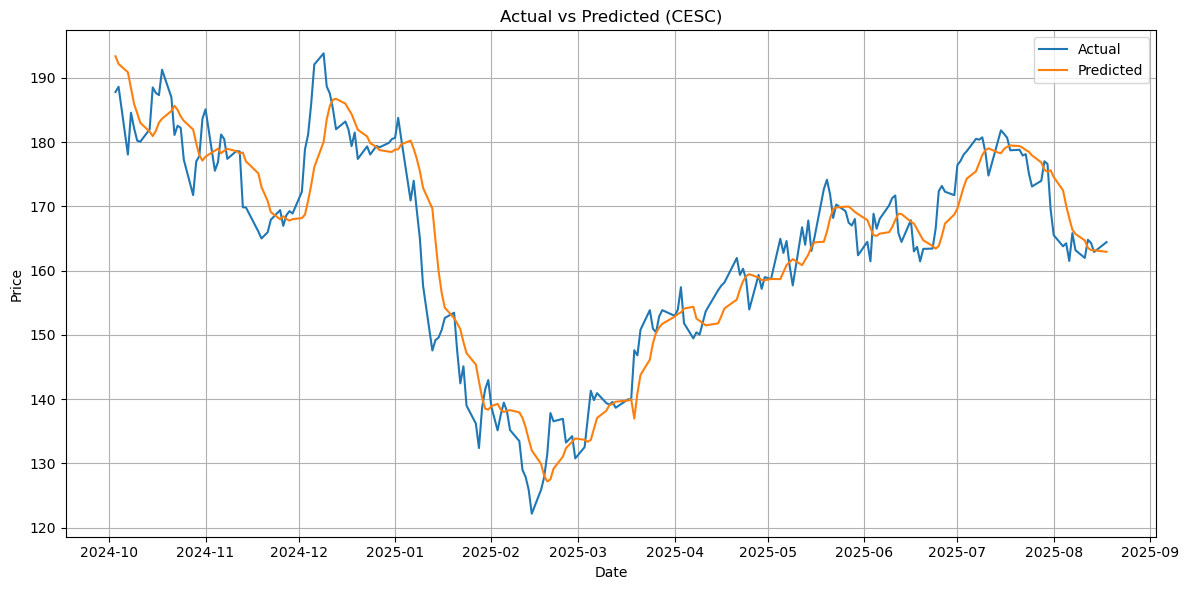

In [8]:
# Example full pipeline - guarded by a flag to prevent accidental heavy runs
run_full_pipeline = True  # set to True if you want to execute the full pipeline including training

if run_full_pipeline:
    # 1) Load data
    df = load_ticker_data('CESC.NS', period='5y', interval='1d')
    # 2) Quick EDA
    quick_eda(df)
    # 3) Preprocess
    df = round_numeric_columns(df, 2)
    df = handle_volume_skew(df, method='log1p')
    # 4) Scale
    scaled, scaler, feature_cols = scale_features(df)
    feature_count = scaled.shape[1]
    # 5) Train/test split (80/20)
    train_size = int(len(scaled) * 0.8)
    train_scaled = scaled[:train_size]
    test_scaled = scaled[train_size:]
    # 6) Create sequences (lookback from tuning)
    lookback = 30
    X_train, y_train = create_sequences(train_scaled, lookback=lookback, target_col_index=feature_cols.index('Close'))
    X_test, y_test = create_sequences(test_scaled, lookback=lookback, target_col_index=feature_cols.index('Close'))
    print('Shapes ->', X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    # 7) Build model
    model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]), units=100, dropout=0.4, lr=0.001)
    # 8) Train model (reduce epochs for quick runs)
    history = train_model(model, X_train, y_train, X_val=X_test, y_val=y_test, epochs=20, batch_size=32)
    # 9) Predict and inverse transform
    y_pred_scaled = model.predict(X_test).flatten()
    y_test_inv = inverse_transform_predictions(y_test, scaler, feature_count, target_col_index=feature_cols.index('Close'))
    y_pred_inv = inverse_transform_predictions(y_pred_scaled, scaler, feature_count, target_col_index=feature_cols.index('Close'))
    # 10) Metrics and plot
    metrics = compute_metrics(y_test_inv, y_pred_inv)
    print('Evaluation metrics:', metrics)
    # Dates for plotting
    all_dates = pd.to_datetime(list(df.index))
    test_dates = all_dates[train_size + lookback: train_size + lookback + len(y_test_inv)]
    plot_actual_vs_pred(test_dates, y_test_inv, y_pred_inv, title='Actual vs Predicted (CESC)')

#### Forecast of price

In [9]:
# Number of days to forecast
future_days = 7

# Start with the last 'lookback' days from your dataset
last_sequence = scaled[-lookback:].copy()
forecast = []

for _ in range(future_days):
    # Reshape for model input
    X_input = np.expand_dims(last_sequence, axis=0)  # shape: (1, lookback, features)
    
    # Predict the next day's closing price
    pred_scaled = model.predict(X_input)
    
    # Store only the predicted closing price (assuming it's the first column in scaler)
    forecast.append(pred_scaled[0, 0])
    
    # Create the next day input row: use predicted close + keep other features same as last day
    next_day = last_sequence[-1].copy()  # last row of features
    next_day[0] = pred_scaled[0, 0]      # replace close price with prediction
    
    # Append new row and keep length
    last_sequence = np.vstack([last_sequence[1:], next_day])

# Convert forecast list to array for inverse scaling
forecast_array = np.zeros((future_days, scaled.shape[1]))  # same feature size
forecast_array[:, 0] = forecast  # set close price predictions

# Inverse transform to get actual close prices
forecast_prices = scaler.inverse_transform(forecast_array)[:, 0]

print("Predicted closing prices:")
print(forecast_prices)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted closing prices:
[163.54721175 163.72525901 163.91551474 164.09946324 164.26749257
 164.41494784 164.53967629]


#### Plot the graph for forecast

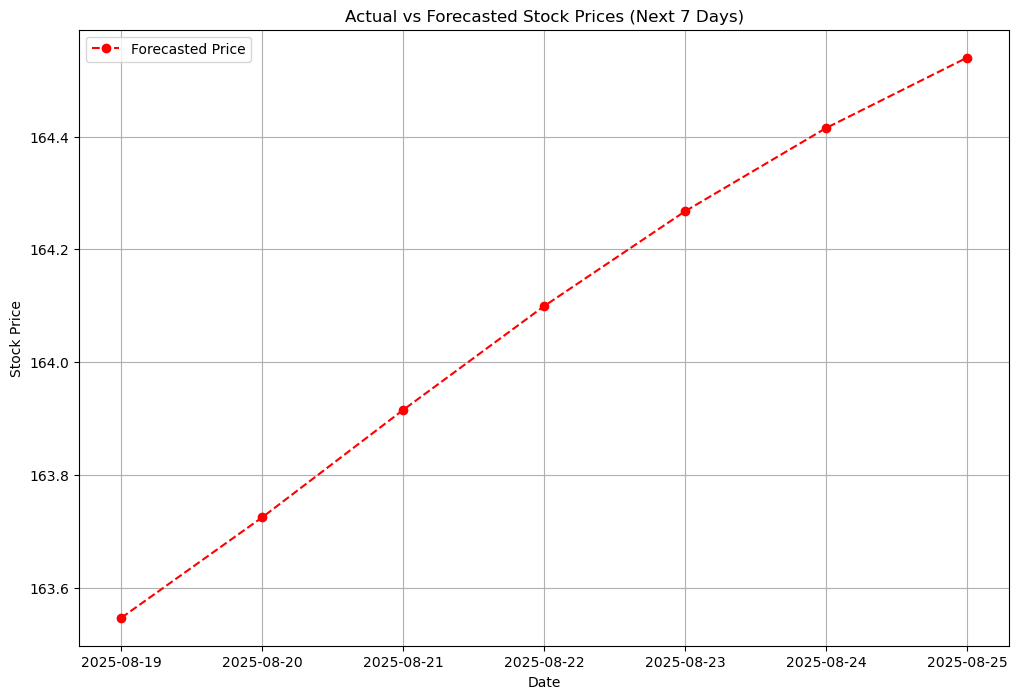

In [10]:
# Create x-axis labels
actual_dates = df.index
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=future_days)
plt.figure(figsize=(12, 8))

# Plot actual prices
# plt.plot(actual_dates, df['Close'], label='Actual Price', color='blue')

# Plot forecasted prices
plt.plot(future_dates, forecast_prices, label='Forecasted Price', color='red', linestyle='--', marker='o')

# Labels and title
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title(f"Actual vs Forecasted Stock Prices (Next {future_days} Days)")
plt.legend()
plt.grid(True)
plt.show()

## 9. Tips & next steps
- Try adding technical indicators (SMA, EMA, RSI, MACD) as additional features.
- Use `keras-tuner` or grid search to automatically find the best hyperparameters.
- Consider ensemble approaches (average of top K models) and stacking for robust predictions.
- Be careful about data leakage: always split before creating sequences or fitting scalers on test data.



# Enhanced LSTM (15‑min, 1‑month) — With Feature Engineering & Reusable Forecast

Adds:
- 15-minute interval data for the last 1 month
- Feature engineering: log returns, rolling volatility, RSI(14)
- Time-series split, scaling on train only
- Improved LSTM + callbacks
- `forecast_lstm()` with arbitrary horizon (2 steps = 30 minutes on 15m)


In [ ]:

import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from math import sqrt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

np.random.seed(42)
tf.random.set_seed(42)


In [ ]:

# === CONFIG ===
TICKER = "ABFRL.NS"   # change as needed
PERIOD = "1mo"
INTERVAL = "15m"
LOOKBACK = 96          # 1 trading day of 15-min bars
TARGET_COL = "Close"

# === Download data ===
data_15m = yf.download(TICKER, period=PERIOD, interval=INTERVAL, auto_adjust=False, progress=False)

if data_15m.empty:
    raise ValueError("No data returned from yfinance. Ensure internet is available and ticker is valid.")

data_15m = data_15m[["Open","High","Low","Close","Volume"]].dropna().copy()
data_15m.index = pd.to_datetime(data_15m.index)
print("Data shape:", data_15m.shape)
data_15m.tail(3)


In [ ]:

df = data_15m.copy()

# Log returns
df["log_ret"] = np.log(df["Close"]).diff()

# Rolling volatility of log returns
df["vol_48"] = df["log_ret"].rolling(48, min_periods=10).std()

# RSI(14)
delta = df["Close"].diff()
gain = (delta.clip(lower=0)).rolling(14, min_periods=14).mean()
loss = (-delta.clip(upper=0)).rolling(14, min_periods=14).mean()
rs = gain / (loss.replace(0, np.nan))
df["rsi14"] = 100 - (100 / (1 + rs))

df = df.fillna(method="bfill").fillna(method="ffill").dropna()

feat_cols = ["Close","Open","High","Low","Volume","log_ret","vol_48","rsi14"]
df = df[feat_cols]

print("Feature matrix shape:", df.shape)
df.tail(3)


In [ ]:

# Time-series split
n = len(df)
train_end = int(n * 0.70)
val_end   = int(n * 0.85)

train_df = df.iloc[:train_end].copy()
val_df   = df.iloc[train_end:val_end].copy()
test_df  = df.iloc[val_end:].copy()

scaler = MinMaxScaler()
scaler.fit(train_df)
train_scaled = scaler.transform(train_df)
val_scaled   = scaler.transform(val_df)
test_scaled  = scaler.transform(test_df)

n_features = train_scaled.shape[1]

def make_sequences(arr, lookback=96, target_index=0):
    X, y = [], []
    for i in range(lookback, len(arr)):
        X.append(arr[i-lookback:i, :])
        y.append(arr[i, target_index])
    return np.array(X), np.array(y)

X_train, y_train = make_sequences(train_scaled, 96, 0)
X_val,   y_val   = make_sequences(val_scaled,   96, 0)
X_test,  y_test  = make_sequences(test_scaled,  96, 0)

print("Shapes ->", X_train.shape, X_val.shape, X_test.shape)


In [ ]:

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(96, n_features)),
    LayerNormalization(),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="mse")

callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)
print("Best val_loss:", np.min(history.history["val_loss"]))


In [ ]:

# Evaluate
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred_scaled = model.predict(X_test, verbose=0).reshape(-1, 1)

temp_pred = np.zeros((len(y_pred_scaled), n_features))
temp_true = np.zeros((len(y_pred_scaled), n_features))

temp_pred[:, 0] = y_pred_scaled[:, 0]
temp_true[:, 0] = y_test

y_pred = scaler.inverse_transform(temp_pred)[:, 0]
y_true = scaler.inverse_transform(temp_true)[:, 0]

rmse = sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-6, None))) * 100

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")

import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(y_true[-300:], label="Actual")
plt.plot(y_pred[-300:], label="Predicted")
plt.title("Test Set — Actual vs Predicted Close")
plt.xlabel("Time (test index)")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

def forecast_lstm(model, scaled_full, scaler, lookback=96, steps=2):
    """Recursive multi-step forecast on scaled data.
    steps=2 -> next 30 minutes (15m interval).
    Assumes target column is index 0 (Close).
    """
    seq = scaled_full[-lookback:, :].copy()
    preds = []
    for _ in range(steps):
        X_in = seq.reshape((1, lookback, scaled_full.shape[1]))
        p = model.predict(X_in, verbose=0)[0, 0]
        preds.append(p)
        # update sequence
        new_row = seq[-1, :].copy()
        new_row[0] = p
        seq = np.vstack([seq[1:], new_row])
    temp = np.zeros((steps, scaled_full.shape[1]))
    temp[:, 0] = preds
    return scaler.inverse_transform(temp)[:, 0]

scaled_full = scaler.transform(df)
future_prices_30min = forecast_lstm(model, scaled_full, scaler, lookback=96, steps=2)
print("Next 30 minutes forecast:", future_prices_30min)


In [ ]:

last_time = df.index[-1]
future_times = pd.date_range(start=last_time, periods=2+1, freq="15min")[1:]

plt.figure(figsize=(12,6))
plt.plot(df.index[-300:], df["Close"].iloc[-300:], label="Historical Close")
plt.plot(future_times, future_prices_30min, "o--", label="30 min Forecast")
plt.title(f"{TICKER} — 15m Forecast (next 30 mins)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()
